# LoRA Fine-tuning of ViT Model for NZ Bird Sound Classification

In [ ]:
from datasets import load_dataset, DatasetDict, Audio
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoImageProcessor, AutoModelForImageClassification, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
import os
import torch
from peft import PeftModel, LoraConfig, get_peft_model
import evaluate
import numpy as np
from collections import Counter
from PIL import Image
import json
from collections import defaultdict
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

model_name = "google/vit-base-patch16-224-in21k"
segments_dir = "./segments" # Directory containing the segmented audio files (segments/{bird_name}/{recording_name}.wav)
output_dir = "./vit-base-manuai"

In [13]:
# Load datasets
# Directory structure:
# segments/
#   ├── tui/
#   ├── bellbird/
#   ├── kaka/
    #   ├── {scientific_name}_{scientific_subspecies}/
    #   │   ├── {id}_{english_name}_{scientific_name}_{scientific_subspecies}_call_segment_0.wav
    #   │   ├── {id}_{english_name}_{scientific_name}_{scientific_subspecies}_call_segment_1.wav
    #   │   ├── {id}_{english_name}_{scientific_name}_{scientific_subspecies}_call_segment_2.wav
#   ├── etc.

dataset = load_dataset(
    "audiofolder",
    data_dir=segments_dir,
    split="train",
)

# Set audio feature to not decode automatically to avoid torchcodec dependency
dataset = dataset.cast_column("audio", Audio(decode=False))

print(f"Loaded dataset with {len(dataset)} examples")

Loaded dataset with 28706 examples


In [14]:
def convert_to_mel_spectrogram(example):
    audio_path = example["audio"]["path"]
    y, sr = librosa.load(audio_path, sr=44100) # 44.1 kHz is a common sampling rate for bird sounds
    mel_spectrogram = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=128, # Number of mel bands (more bands can capture more detail)
        n_fft=2048, # FFT window size 
        hop_length=512, # Hop length for STFT
        win_length=2048, # Window length for STFT
        window='hann', # Window function
        fmin=50, # Minimum frequency
        fmax=sr//2 # Maximum frequency (Nyquist frequency for the given sample rate)
    )
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=1.0) # Convert to dB scale
    
    # Convert to PIL Image instead of list
    # Normalize the spectrogram to 0-255 range for image processing
    normalized = ((mel_spectrogram_db - mel_spectrogram_db.min()) / 
                 (mel_spectrogram_db.max() - mel_spectrogram_db.min()) * 255).astype(np.uint8)
    
    # Convert to 3-channel image (RGB) by repeating the grayscale values
    rgb_image = np.stack([normalized] * 3, axis=0)  # Shape: (3, height, width)
    rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Shape: (height, width, 3)
    
    example["image"] = Image.fromarray(rgb_image)
    return example

def convert_to_linear_spectrogram(example):
    audio_path = example["audio"]["path"]
    y, sr = librosa.load(audio_path, sr=44100)  # Load audio at 44.1 kHz
    linear_spectrogram = librosa.stft(y, n_fft=2048, hop_length=512, win_length=2048)
    linear_spectrogram_db = librosa.amplitude_to_db(np.abs(linear_spectrogram), ref=np.max)
    
    # Convert to PIL Image instead of list
    normalized = ((linear_spectrogram_db - linear_spectrogram_db.min()) / 
                 (linear_spectrogram_db.max() - linear_spectrogram_db.min()) * 255).astype(np.uint8)
    
    # Convert to 3-channel image (RGB) by repeating the grayscale values
    rgb_image = np.stack([normalized] * 3, axis=0)  # Shape: (3, height, width)
    rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Shape: (height, width, 3)
    
    example["image"] = Image.fromarray(rgb_image)
    return example

def extract_bird_name_from_filename(example):
    """
    Extract the English bird name from the filename.
    Filename format: {file_id}_{english_name}_{scientific_specie}_{scientific_subspecie}_{song or call}.wav
    We want the {english_name} part (second element after splitting by underscore).
    """
    audio_path = example["audio"]["path"]
    # Get just the filename without the path
    filename = os.path.basename(audio_path)
    # Remove the .wav extension
    filename_without_ext = os.path.splitext(filename)[0]
    # Split by underscore and get the english name (second element)
    parts = filename_without_ext.split('_')
    if len(parts) >= 2:
        english_name = parts[1]  # Second element is the English name
    else:
        # Fallback if filename doesn't match expected format
        english_name = "unknown"
    
    example["class"] = english_name
    return example

dataset = dataset.map(
    extract_bird_name_from_filename,
    remove_columns=["label"],
    desc="Extracting bird names from filenames"
)

# Apply mel spectrogram conversion to the dataset
dataset = dataset.map(
    convert_to_mel_spectrogram,
    remove_columns=["audio"],
    desc="Converting to mel spectrograms"
)

# dataset = dataset.map(
#     convert_to_linear_spectrogram,
#     remove_columns=["audio"],
#     desc="Converting to linear spectrograms"
# )
dataset

Dataset({
    features: ['class', 'image'],
    num_rows: 28706
})

In [15]:
train, test = dataset.train_test_split(test_size=0.2, seed=42).values()

dataset_dict = DatasetDict({
    "train": train,
    "test": test,
})

# Access spectrogram path instead of decoded audio to avoid torchcodec
print(f"Number of training samples: {len(dataset_dict['train'])}")
print(f"Number of test samples: {len(dataset_dict['test'])}")
print(f"Sample spectrogram path: {dataset_dict['train'][10]['image'].filename}")  # Show path to the spectrogram image
print(f"Sample class: {dataset_dict['train'][10]['class']}")  # Show class label

# Show the dataset structure
print(f"\nDataset features: {dataset_dict['train'].features}")

Number of training samples: 22964
Number of test samples: 5742
Sample spectrogram path: 
Sample class: robin

Dataset features: {'class': Value('string'), 'image': Image(mode=None, decode=True)}


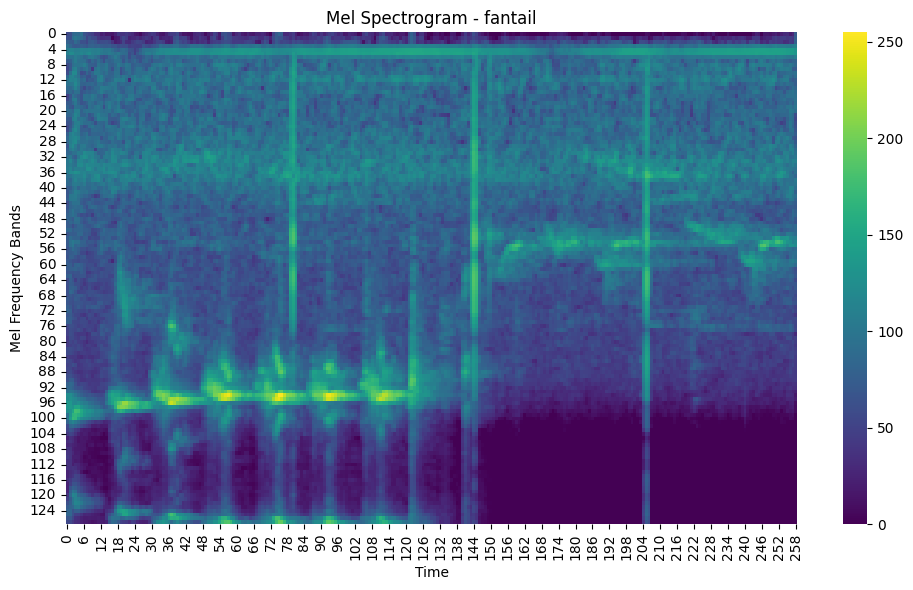

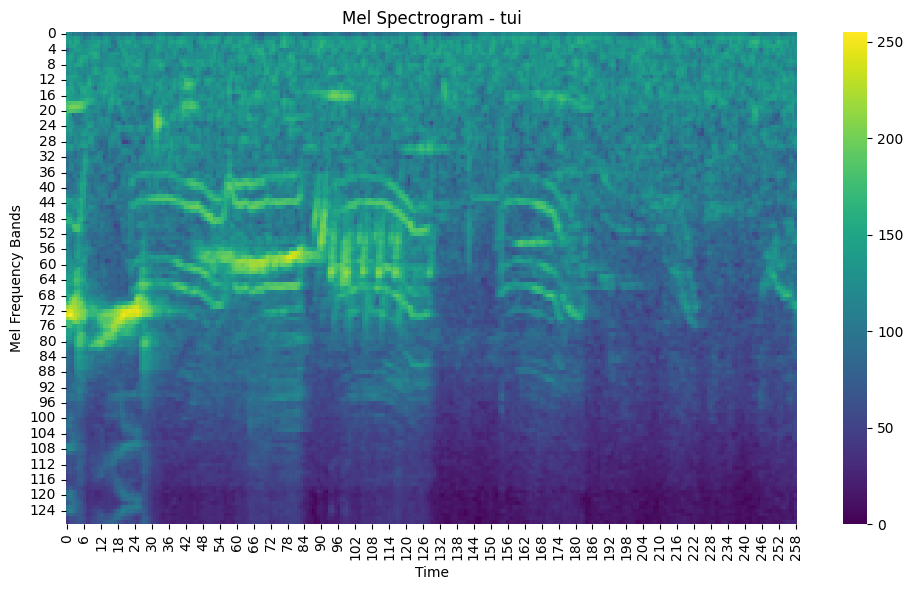

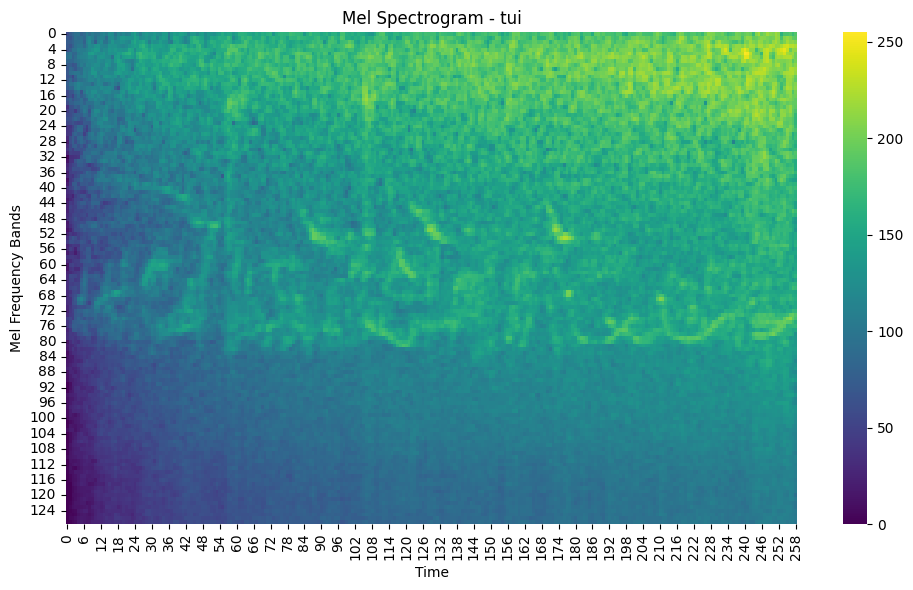

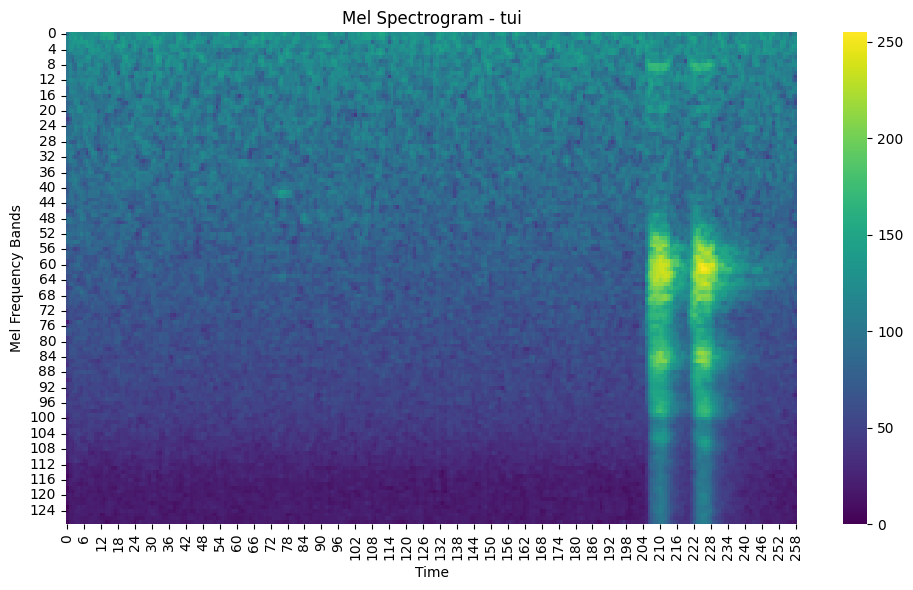

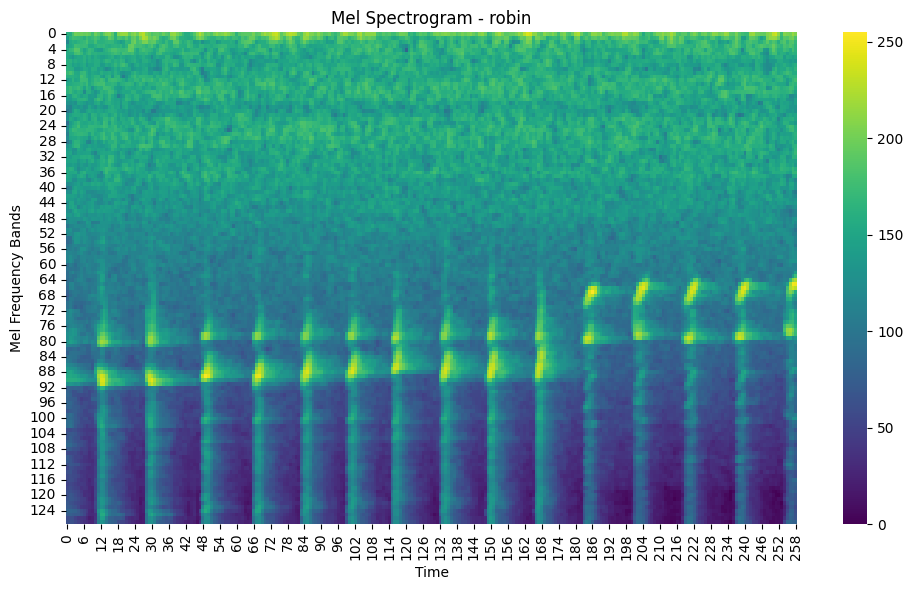

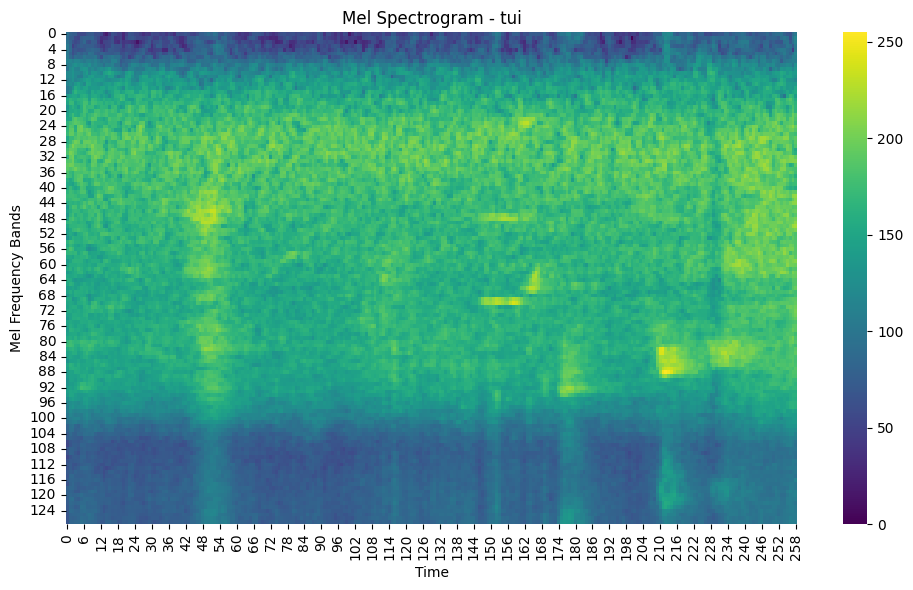

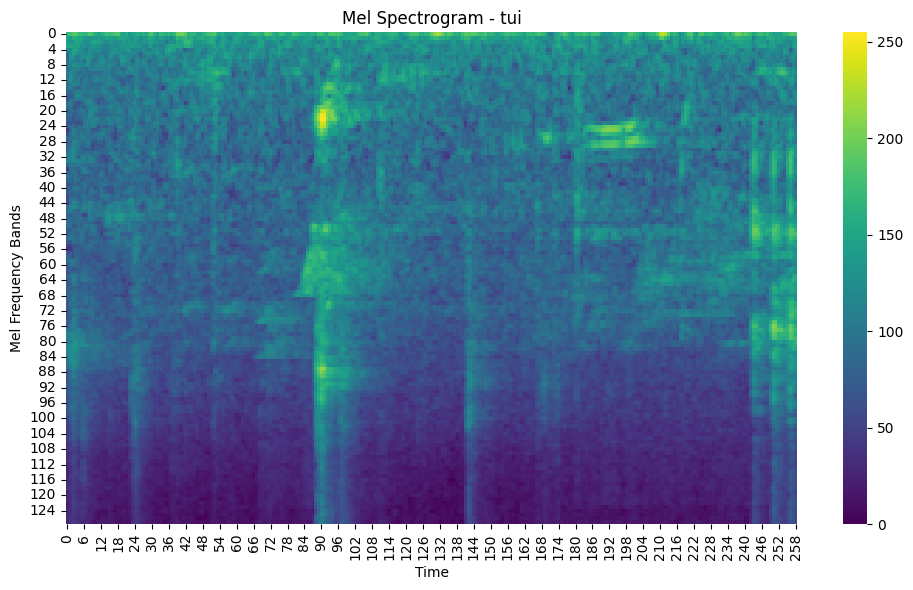

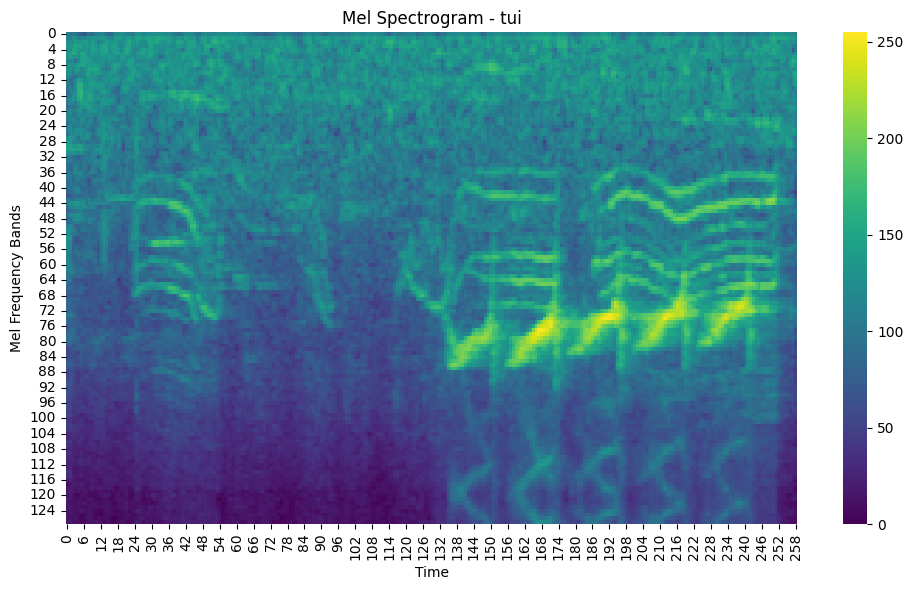

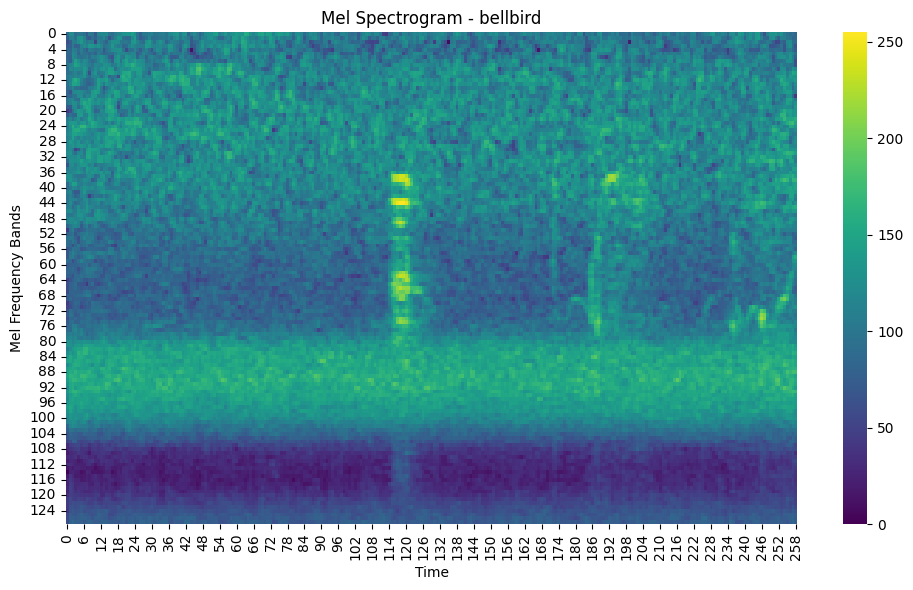

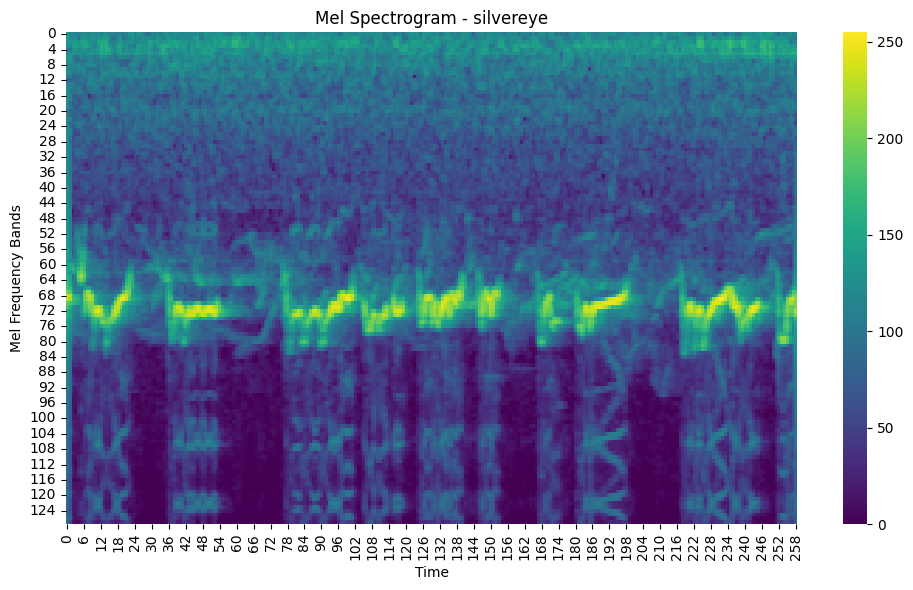

In [16]:
# Plotting mel spectrograms for visualization
def plot_spectrogram(spectrogram, title="Mel Spectrogram"):
    # Convert PIL Image to numpy array and extract single channel for heatmap
    if isinstance(spectrogram, Image.Image):
        spectrogram_array = np.array(spectrogram)
    else:
        spectrogram_array = spectrogram
    
    # If it's RGB (3 channels), take only the first channel since all channels are identical
    if len(spectrogram_array.shape) == 3:
        spectrogram_2d = spectrogram_array[:, :, 0]  # Take first channel
    else:
        spectrogram_2d = spectrogram_array
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(spectrogram_2d, cmap='viridis', cbar=True)
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency Bands')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot a few mel spectrograms from the training set
for i in range(10):  # Show first 10 examples
    spectrogram = dataset_dict['train'][i]['image']
    bird_class = dataset_dict['train'][i]['class']
    plot_spectrogram(spectrogram, title=f"Mel Spectrogram - {bird_class}")

In [ ]:
# Get all class labels without triggering repeated filtering
temp_train = dataset_dict['train'].with_format(None)
all_classes = [item['class'] for item in temp_train]
class_counts = Counter(all_classes)

print("📊 Class Distribution:")
print("=" * 40)
total_samples = sum(class_counts.values())

# Sort by count (descending) for better visualization
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

for bird_class, count in sorted_classes:
    percentage = (count / total_samples) * 100
    print(f"{bird_class:12}: {count:5,} ({percentage:5.1f}%)")

print("=" * 40)
print(f"{'Total':12}: {total_samples:5,} (100.0%)")
print(f"{'Classes':12}: {len(class_counts):5}")

# Check for class imbalance
max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count

print(f"\n⚖️  Class Balance Analysis:")
print(f"   • Most samples: {max_count:,} ({sorted_classes[0][0]})")
print(f"   • Least samples: {min_count:,} ({sorted_classes[-1][0]})")
print(f"   • Imbalance ratio: {imbalance_ratio:.1f}:1")

📊 Class Distribution:
tui         : 9,149 ( 39.8%)
bellbird    : 3,673 ( 16.0%)
robin       : 1,813 (  7.9%)
silvereye   : 1,539 (  6.7%)
whitehead   : 1,457 (  6.3%)
fantail     : 1,335 (  5.8%)
kaka        : 1,218 (  5.3%)
saddleback  : 1,071 (  4.7%)
tomtit      :   942 (  4.1%)
morepork    :   767 (  3.3%)
Total       : 22,964 (100.0%)
Classes     :    10

⚖️  Class Balance Analysis:
   • Most samples: 9,149 (tui)
   • Least samples: 767 (morepork)
   • Imbalance ratio: 11.9:1


In [ ]:
# Give user option on how many spectrograms per specie for training
num_spectrograms_per_class = int(input(f"Enter the number of spectrograms per class for training (min = {min_count}, max = {max_count}, 0 for all): "))
if num_spectrograms_per_class > 0:
    # Group indices by class in a single pass
    class_to_indices = defaultdict(list)
    for idx, example in enumerate(dataset_dict['train']):
        class_to_indices[example['class']].append(idx)
    
    selected_indices = []
    for cls, indices in class_to_indices.items():
        np.random.shuffle(indices)
        selected_indices.extend(indices[:num_spectrograms_per_class])
    
    # Sort indices to optimise dataset selection
    selected_indices = sorted(selected_indices)
    
    # Create filtered dataset
    filtered_train = dataset_dict['train'].select(selected_indices)
    dataset_dict['train'] = filtered_train
else:
    print("Using all spectrograms in the dataset.")

In [19]:
image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

# pipeline for preprocessing images to get same shape and scaling
preprocess_image = Compose([
    Resize(image_processor.size["height"]),
    CenterCrop(image_processor.size["height"]),
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

# function to apply above preprocessing to a batch (train or test)
def preprocess(batch):
    batch["pixel_values"] = [
        preprocess_image(image.convert("RGB")) for image in batch["image"]
    ]
    return batch

# Set the transform for the datasets
dataset_dict["train"].set_transform(preprocess)
dataset_dict["test"].set_transform(preprocess)

print(f"Training set size: {len(dataset_dict['train'])}, Test set size: {len(dataset_dict['test'])}")

Training set size: 5000, Test set size: 5742


In [20]:
def print_model_size(path):
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)

    print(f"Model Size: {(size / 1e6):.2} MB")


def print_trainable_parameters(model, label):
    params, trainable = 0, 0
    
    for _, p in model.named_parameters():
        params += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    print(f"{label} trainable parameters: {trainable:,}/{params:,} ({100 * trainable / params:.2f}%)")


In [21]:
metric = evaluate.load("accuracy")

'''
# if you want to use quantized lora fine-tuning
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
'''

def data_collator(batch):
    """
    Custom data collator to handle batches of images and labels.
    Converts pixel values to tensors and labels to a tensor.
    """
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    """    
    Compute accuracy metrics for the evaluation predictions.
    Extracts predictions and computes accuracy using the evaluate library.
    """
    eval_pred = eval_pred
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)


def get_base_model(label2id, id2label):
    """    
    Load the base model for image classification.
    This function initializes the model with the specified label mappings.
    """
    print(f"Loading base model: {model_name}")
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True,
    #   quantization_config=bnb_config,
    #   device_map="auto",
    )
    # REMOVED: model.config.class_weights = class_weights_tensor
    # This was causing JSON serialization error in TensorBoard
    return model


# Custom trainer class to handle class weights properly
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Custom loss function with class weights for handling imbalanced data.
        """
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        if self.class_weights is not None:
            # Move class weights to the same device as logits
            device_weights = self.class_weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=device_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


def build_lora_model(label2id, id2label):
    """
    Build the LoRA model for fine-tuning.
    This function initializes the base model and applies LoRA configuration.
    """
    print("Building LoRA model...")
    base_model = get_base_model(label2id, id2label)
    print_trainable_parameters(base_model, label="Base Model")

    config = LoraConfig(
        r=16, # Rank of the LoRA layers
        lora_alpha=16, # Scaling factor for the LoRA layers
        target_modules=["query", "value"], # Target modules for LoRA
        lora_dropout=0.1, # Dropout rate for LoRA layers
        bias="none", # No bias in LoRA layers
        modules_to_save=["classifier"], # Modules to save during LoRA fine-tuning
    )

    lora_model = get_peft_model(base_model, config)
    print_trainable_parameters(lora_model, label="LoRA")

    return lora_model

In [22]:
# Calculate class weights
class_names = list(dataset_dict['train'].unique('class'))
label2id = {name: i for i, name in enumerate(class_names)}
id2label = {i: name for i, name in enumerate(class_names)}
all_classes = [example['class'] for example in dataset_dict['train']]
class_weights = compute_class_weight(
    'balanced',
    classes=np.array(range(len(class_names))),
    y=[label2id[cls] for cls in all_classes]
)

# Convert to dictionary format for PyTorch
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("📊 Calculated Class Weights:")
for class_name, class_id in label2id.items():
    weight = class_weight_dict[class_id]
    print(f"{class_name:12}: {weight:.3f}")

# Add class weights to training arguments
class_weights_tensor = torch.FloatTensor(list(class_weight_dict.values()))

Flattening the indices: 100%|██████████| 5000/5000 [01:21<00:00, 61.13 examples/s]


📊 Calculated Class Weights:
robin       : 1.000
kaka        : 1.000
tui         : 1.000
morepork    : 1.000
fantail     : 1.000
tomtit      : 1.000
saddleback  : 1.000
whitehead   : 1.000
silvereye   : 1.000
bellbird    : 1.000


In [ ]:
batch_size = 64
training_arguments = TrainingArguments(
    output_dir="./model-checkpoints",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4, # Learning rate for fine-tuning
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    fp16=False, # Disable mixed precision training
    bf16=False, # Disable bfloat16 training
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    label_names=["labels"],
    warmup_ratio=0.1, # Warmup ratio for learning rate scheduler
    weight_decay=0.01, # Weight decay for regularization
    dataloader_num_workers=0, # Number of workers for data loading
    report_to=None,  # Disable TensorBoard
)

# Create train/validation split
train_val_split = dataset_dict["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]
test_dataset = dataset_dict["test"]

temp_train = dataset_dict["train"].with_format(None)
unique_classes = sorted(set(temp_train["class"]))
label2id = {label: i for i, label in enumerate(unique_classes)}
id2label = {i: label for label, i in label2id.items()}

print(f"Found {len(unique_classes)} classes: {unique_classes}")
print(f"Label mappings: {label2id}")

# Add early stopping to training arguments
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of epochs with no improvement to wait before stopping
    early_stopping_threshold=0.01  # Minimum change to qualify as an improvement
)

# Create data collator as a class
class CustomDataCollator:
    def __init__(self, label2id_mapping):
        self.label2id_mapping = label2id_mapping
    
    def __call__(self, batch):
        """
        Custom data collator to handle batches of images and labels.
        Converts pixel values to tensors and labels to a tensor.
        """
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        labels = torch.tensor([self.label2id_mapping[item["class"]] for item in batch])
        return {"pixel_values": pixel_values, "labels": labels}

data_collator = CustomDataCollator(label2id)

epochs = 10  # Number of epochs for training
training_arguments.num_train_epochs = epochs
processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

# Use WeightedTrainer instead of regular Trainer
trainer = WeightedTrainer(
    class_weights=class_weights_tensor,  # Pass class weights here
    model=build_lora_model(label2id, id2label),
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],  # Add early stopping callback
    tokenizer=processor,  # Use image processor for tokenization
)

print(f"Class weights being used:")
for i, (class_name, weight) in enumerate(zip(unique_classes, class_weights_tensor.tolist())):
    print(f"  {class_name}: {weight:.3f}")

import tqdm
print(f"Starting training for {epochs} epochs with class weighting...")
results = tqdm.tqdm(trainer.train(), desc="Training Progress", total=epochs)

eval_results = trainer.evaluate(test_dataset)
print(f"Training completed. Evaluation results: {eval_results}")

Found 10 classes: ['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback', 'silvereye', 'tomtit', 'tui', 'whitehead']
Label mappings: {'bellbird': 0, 'fantail': 1, 'kaka': 2, 'morepork': 3, 'robin': 4, 'saddleback': 5, 'silvereye': 6, 'tomtit': 7, 'tui': 8, 'whitehead': 9}
Building LoRA model...
Loading base model: google/vit-base-patch16-224-in21k


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_62370/1390194945.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Base Model trainable parameters: 85,806,346/85,806,346 (100.00%)
LoRA trainable parameters: 597,514/86,403,860 (0.69%)
Class weights being used:
  bellbird: 1.000
  fantail: 1.000
  kaka: 1.000
  morepork: 1.000
  robin: 1.000
  saddleback: 1.000
  silvereye: 1.000
  tomtit: 1.000
  tui: 1.000
  whitehead: 1.000
Starting training for 10 epochs with class weighting...


In [ ]:
trainer.save_model(output_dir)
print_model_size(output_dir)
print_trainable_parameters(trainer.model, label="Final Model")

# Evaluate on validation set
val_results = trainer.evaluate(eval_dataset=val_dataset)
print(f"Validation results: {val_results}")

# Final evaluation on test set
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test results: {test_results}")

# Save model and metrics
trainer.save_model(output_dir)
print_model_size(output_dir)
print_trainable_parameters(trainer.model, label="Final Model")

print(f"Model saved to {output_dir}")
print(f"Training completed in {epochs} epochs.")
print(f"Final validation accuracy: {val_results['eval_accuracy']:.2f}")
print(f"Final test accuracy: {test_results['eval_accuracy']:.2f}")

In [ ]:
# TO DO REFERENCE

# Doing the inference
def build_inference_model(label2id, id2label, lora_adapter_path):
    base_model = get_base_model(label2id, id2label)
    return PeftModel.from_pretrained(base_model, lora_adapter_path)


def predict_image_class(image, model, image_processor):
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    class_index = logits.argmax(-1).item()
    return model.config.id2label[class_index]

model = build_inference_model(
    dataset_dict['train']['label2id'],
    dataset_dict['train']['id2label'],
    output_dir
)

processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

In [ ]:
img = dataset2['train'][1234]['image']
print(dataset2_id2label[dataset2['train'][1234]['class']])
print(predict_image_class(img, model, processor))
img

In [ ]:
def calculate_accuracy(dataset, id2label, model, processor):
    correct = 0
    incorrect = 0
    for i in range(len(dataset['test'])):
        img = dataset['test'][i]['image']
        label = dataset['test'][i]['label']
        pred = predict(img, model, processor)
        
        if id2label[label] == pred:
            correct += 1
        else:
            incorrect += 1
            
    return correct, incorrect, (correct / (len(dataset['test'])))

correct, incorrect, accuracy = calculate_accuracy(dataset2, model, processor)

In [ ]:
!zip -r lora-manuai.zip lora-manuai-model